In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
from water_pollution.data.preproc import *
from water_pollution.data import stations
from water_pollution.data import weather

from water_pollution.data import visu

In [59]:
# Builds the small training df (from saone data between 2011-2021)
file_path = '../../raw_data/pc_saone_2011_2021/Analyses.CSV'
rawdf = get_rawdf_from_file(file_path)
da_df = build_saone_base_training_data(rawdf)

In [60]:
stationsdf = stations.get_saone_stations_df()
# stationsdf.sort_values('alt')

In [61]:
from tensorflow.keras import models, layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [73]:
df = da_df.copy()

In [74]:
mean_nitrate = df.groupby('station_id',as_index=False).mean()[['station_id','nitrate']]
mean_nitrate.columns = ['station_id','mean_station']

In [75]:
df_with_mean = pd.merge(df,mean_nitrate,on='station_id',how='left')
df = df_with_mean

In [76]:
weather10df = weather.get_saone_weather_df(window_size=15)

In [78]:
mergeddf = pd.merge(df,weather10df,on=['date','station_id'],how='left')

In [79]:
df = mergeddf.dropna()

In [80]:
df

,date,year,sin_doy,cos_doy,station_id,source_dist,nitrate,mean_station,temp,precipitation
0,2013-01-28,2013,0.448229,0.893919,6000990,5.827388,4.3,4.513699,-2.560000,2.553333
1,2013-03-25,2013,0.989932,0.141540,6000990,5.827388,3.8,4.513699,2.580000,2.893333
2,2013-05-29,2013,0.559589,-0.828770,6000990,5.827388,3.5,4.513699,9.833333,7.360000
3,2013-07-22,2013,-0.329408,-0.944188,6000990,5.827388,4.9,4.513699,21.960000,0.100000
4,2013-09-23,2013,-0.988678,-0.150055,6000990,5.827388,5.1,4.513699,12.453333,7.806667
...,...,...,...,...,...,...,...,...,...,...
1874,2021-04-14,2021,0.979614,-0.200891,6810010,236.942892,10.0,8.468874,9.253333,2.633333
1875,2021-04-07,2021,0.996659,-0.081676,6810010,236.942892,11.0,8.468874,10.673333,0.406667
1876,2021-05-28,2021,0.573772,-0.819015,6810010,236.942892,9.0,8.468874,12.426667,4.293333
1877,2021-06-25,2021,0.128748,-0.991677,6810010,236.942892,7.8,8.468874,21.920000,7.286667


In [81]:
# TRAIN / TEST SPLIT

feature_cols = [
    'sin_doy',
    'cos_doy',
    'mean_station',
    'temp',
    'precipitation',
    # 'source_dist',
    # 'year'
]

X = df[feature_cols]
y = df['nitrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# PREPROCESSING

# Fit on X_train
scaler = StandardScaler()
scaler.fit(X_train)

# Transform all the X
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [82]:
assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

In [83]:
def init_model(X):
    
    model = models.Sequential()
    
    model.add(layers.Dense(20,activation='relu',input_dim=X.shape[1]))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(20,activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    
    model.add(layers.Dense(10,activation='relu'))
    model.add(layers.Dropout(rate=0.4))
    
    model.add(layers.Dense(1,activation='linear'))
    
    return model

model = init_model(X)
model.compile(loss='mse', optimizer='adam')

es = EarlyStopping(
	patience=100,
	monitor='val_loss',
	restore_best_weights=True
)

history = model.fit(
	X_train,y_train,
	epochs=2000,  # set it to a large value, early stoping will stop the fit
	batch_size=32, # good values : 16 or 32
	callbacks=[es],
	validation_data=(X_test, y_test),
	verbose=1
)

2021-11-29 20:40:07.742622: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-29 20:40:07.742651: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-29 20:40:07.742673: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2021-11-29 20:40:07.742909: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-29 20:40:07.827255: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimiz

Epoch 1/2000
41/41 [==============================] - 0s 4ms/step - loss: 90.7135 - val_loss: 78.8429
Epoch 2/2000
41/41 [==============================] - 0s 2ms/step - loss: 67.6256 - val_loss: 44.3034
Epoch 3/2000
41/41 [==============================] - 0s 1ms/step - loss: 35.1339 - val_loss: 15.3565
Epoch 4/2000
41/41 [==============================] - 0s 1ms/step - loss: 25.7981 - val_loss: 12.2898
Epoch 5/2000
41/41 [==============================] - 0s 1ms/step - loss: 23.1817 - val_loss: 12.0143
Epoch 6/2000
41/41 [==============================] - 0s 1ms/step - loss: 21.1544 - val_loss: 10.5990
Epoch 7/2000
41/41 [==============================] - 0s 2ms/step - loss: 20.3867 - val_loss: 10.2980
Epoch 8/2000
41/41 [==============================] - 0s 3ms/step - loss: 19.8515 - val_loss: 9.6046
Epoch 9/2000
41/41 [==============================] - 0s 2ms/step - loss: 19.1328 - val_loss: 9.4142
Epoch 10/2000
41/41 [==============================] - 0s 2ms/step - loss: 19.7131 -

41/41 [==============================] - 0s 2ms/step - loss: 14.5134 - val_loss: 7.9909
Epoch 82/2000
41/41 [==============================] - 0s 2ms/step - loss: 13.8667 - val_loss: 6.9911
Epoch 83/2000
41/41 [==============================] - 0s 2ms/step - loss: 12.6441 - val_loss: 7.0100
Epoch 84/2000
41/41 [==============================] - 0s 3ms/step - loss: 13.4850 - val_loss: 7.5768
Epoch 85/2000
41/41 [==============================] - 0s 2ms/step - loss: 13.4649 - val_loss: 7.0746
Epoch 86/2000
41/41 [==============================] - 0s 2ms/step - loss: 12.3901 - val_loss: 7.2356
Epoch 87/2000
41/41 [==============================] - 0s 1ms/step - loss: 13.1886 - val_loss: 7.1431
Epoch 88/2000
41/41 [==============================] - 0s 1ms/step - loss: 13.3343 - val_loss: 7.0317
Epoch 89/2000
41/41 [==============================] - 0s 2ms/step - loss: 13.1526 - val_loss: 7.1575
Epoch 90/2000
41/41 [==============================] - 0s 2ms/step - loss: 13.2032 - val_loss: 7

Epoch 161/2000
41/41 [==============================] - 0s 2ms/step - loss: 11.6390 - val_loss: 6.6035
Epoch 162/2000
41/41 [==============================] - 0s 2ms/step - loss: 10.6834 - val_loss: 6.6043
Epoch 163/2000
41/41 [==============================] - 0s 2ms/step - loss: 10.3841 - val_loss: 6.4958
Epoch 164/2000
41/41 [==============================] - 0s 2ms/step - loss: 10.3836 - val_loss: 6.6855
Epoch 165/2000
41/41 [==============================] - 0s 1ms/step - loss: 10.6773 - val_loss: 6.7338
Epoch 166/2000
41/41 [==============================] - 0s 1ms/step - loss: 11.0522 - val_loss: 6.6484
Epoch 167/2000
41/41 [==============================] - 0s 1ms/step - loss: 10.5902 - val_loss: 6.4859
Epoch 168/2000
41/41 [==============================] - 0s 2ms/step - loss: 10.8133 - val_loss: 6.4683
Epoch 169/2000
41/41 [==============================] - 0s 2ms/step - loss: 9.9281 - val_loss: 6.6848
Epoch 170/2000
41/41 [==============================] - 0s 2ms/step - loss

41/41 [==============================] - 0s 2ms/step - loss: 9.3438 - val_loss: 6.4867
Epoch 242/2000
41/41 [==============================] - 0s 2ms/step - loss: 9.1887 - val_loss: 6.1976
Epoch 243/2000
41/41 [==============================] - 0s 1ms/step - loss: 9.2445 - val_loss: 6.4893
Epoch 244/2000
41/41 [==============================] - 0s 1ms/step - loss: 9.4207 - val_loss: 6.2142
Epoch 245/2000
41/41 [==============================] - 0s 1ms/step - loss: 9.2224 - val_loss: 6.2097
Epoch 246/2000
41/41 [==============================] - 0s 1ms/step - loss: 9.2470 - val_loss: 6.1132
Epoch 247/2000
41/41 [==============================] - 0s 1ms/step - loss: 9.3576 - val_loss: 6.3769
Epoch 248/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.8518 - val_loss: 6.3559
Epoch 249/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.9897 - val_loss: 6.2238
Epoch 250/2000
41/41 [==============================] - 0s 2ms/step - loss: 8.8605 - val_loss: 6.

41/41 [==============================] - 0s 2ms/step - loss: 8.6907 - val_loss: 6.2260
Epoch 322/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.4806 - val_loss: 6.1648
Epoch 323/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.2030 - val_loss: 6.2687
Epoch 324/2000
41/41 [==============================] - 0s 2ms/step - loss: 8.5606 - val_loss: 6.3058
Epoch 325/2000
41/41 [==============================] - 0s 2ms/step - loss: 8.4235 - val_loss: 6.2054
Epoch 326/2000
41/41 [==============================] - 0s 2ms/step - loss: 9.0402 - val_loss: 6.1414
Epoch 327/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.4709 - val_loss: 6.1537
Epoch 328/2000
41/41 [==============================] - 0s 2ms/step - loss: 8.4021 - val_loss: 6.1209
Epoch 329/2000
41/41 [==============================] - 0s 2ms/step - loss: 8.3036 - val_loss: 6.1359
Epoch 330/2000
41/41 [==============================] - 0s 2ms/step - loss: 8.4700 - val_loss: 6.

41/41 [==============================] - 0s 1ms/step - loss: 7.6191 - val_loss: 5.9571
Epoch 402/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.4605 - val_loss: 6.0597
Epoch 403/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.3596 - val_loss: 5.9746
Epoch 404/2000
41/41 [==============================] - 0s 2ms/step - loss: 8.2944 - val_loss: 6.0514
Epoch 405/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.3258 - val_loss: 6.2795
Epoch 406/2000
41/41 [==============================] - 0s 1ms/step - loss: 7.8018 - val_loss: 6.0783
Epoch 407/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.4444 - val_loss: 6.1421
Epoch 408/2000
41/41 [==============================] - 0s 1ms/step - loss: 7.7144 - val_loss: 5.9729
Epoch 409/2000
41/41 [==============================] - 0s 1ms/step - loss: 7.9062 - val_loss: 6.0296
Epoch 410/2000
41/41 [==============================] - 0s 1ms/step - loss: 8.0656 - val_loss: 6.

In [84]:
def plot_loss(history, title=None):
    fig = plt.figure(figsize=(20,7))
    
    # --- LOSS --- 
    ax = plt.gca()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,100))
    ax.legend(['Train', 'Test'], loc='best')
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

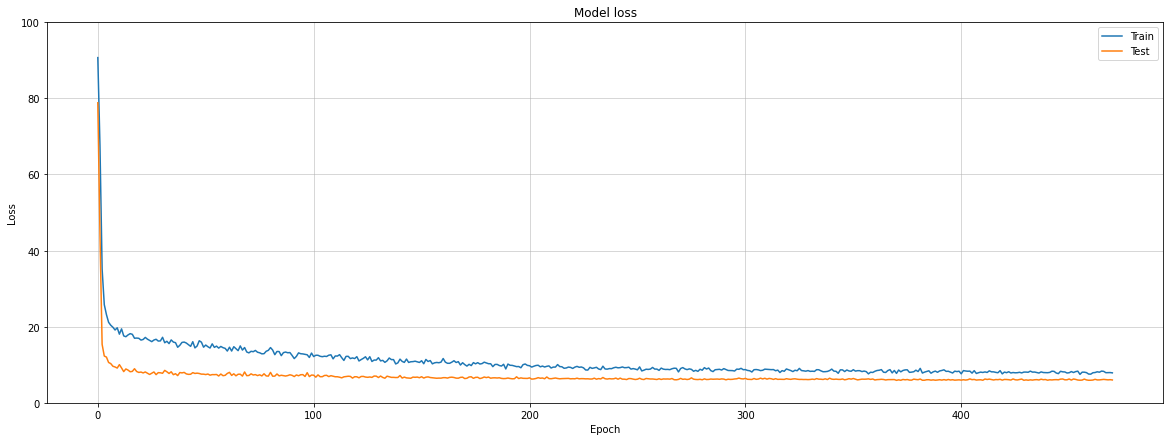

In [85]:
plot_loss(history)

6000990


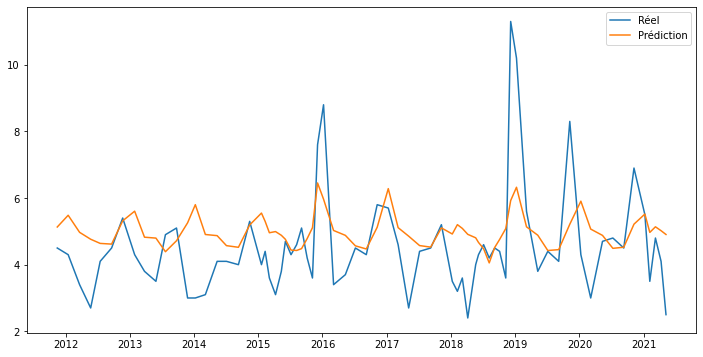

6000993


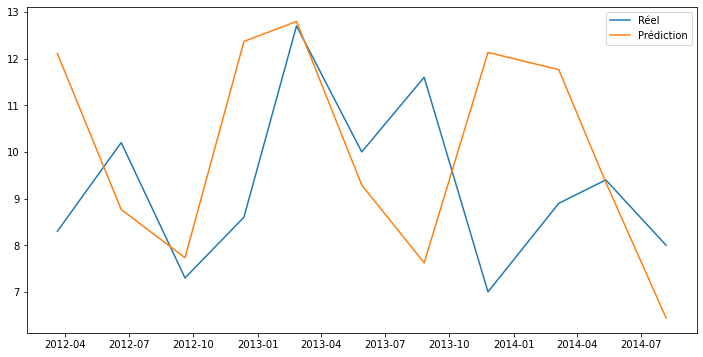

6000998


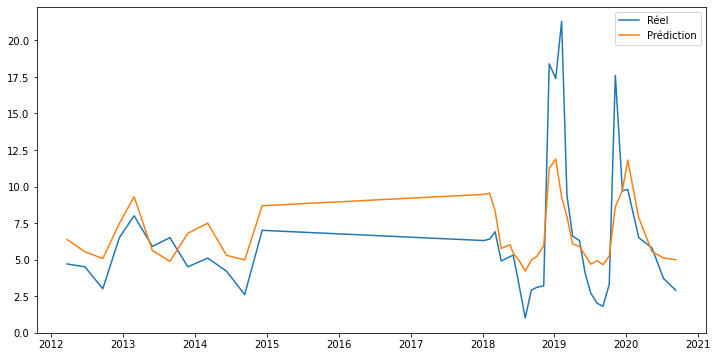

6001000


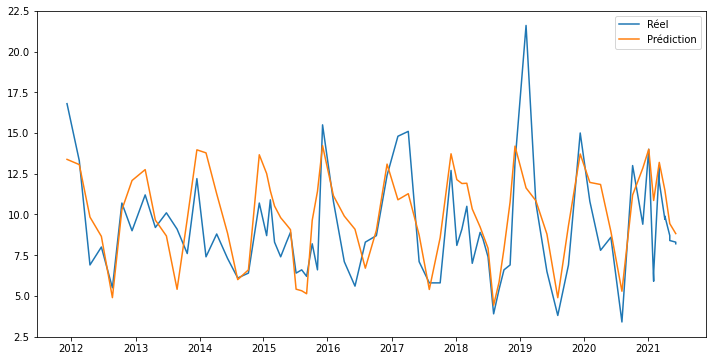

6002500


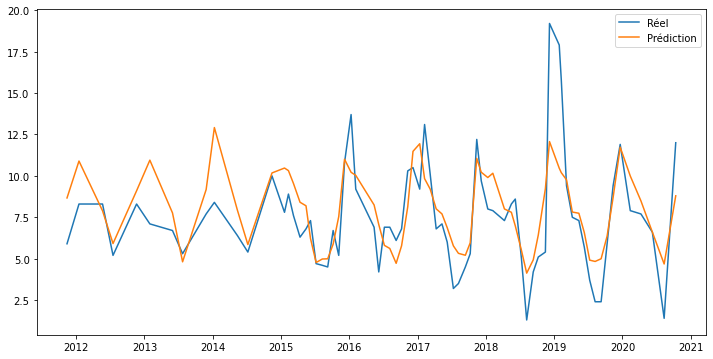

6003600


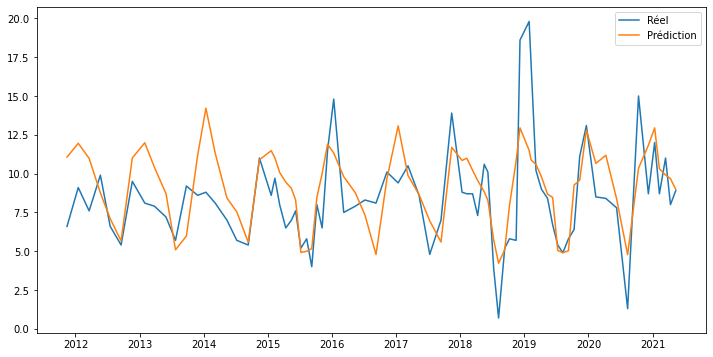

6005500


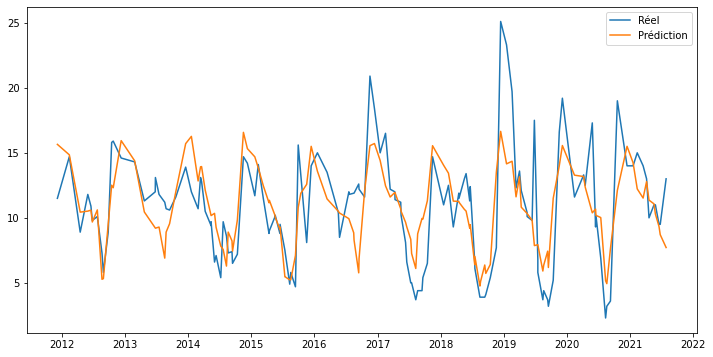

6011000


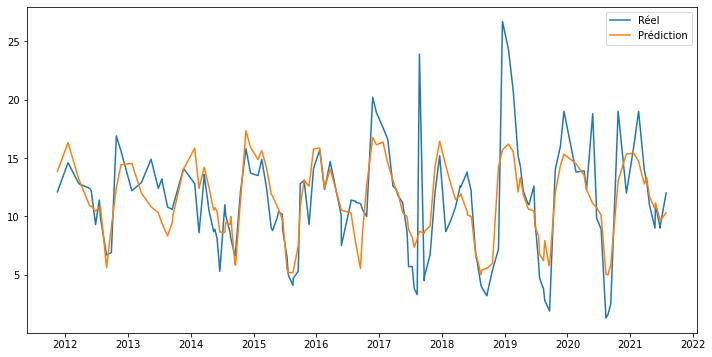

6017050


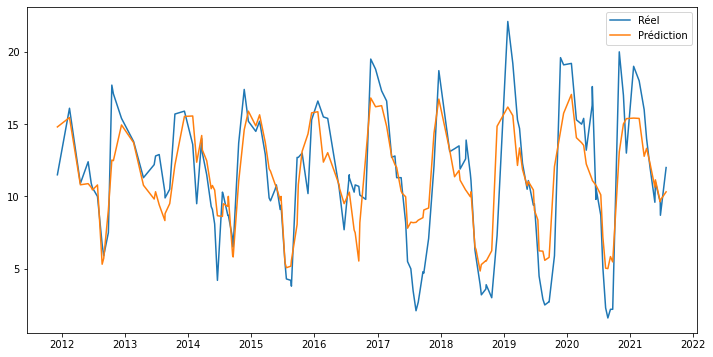

6017070


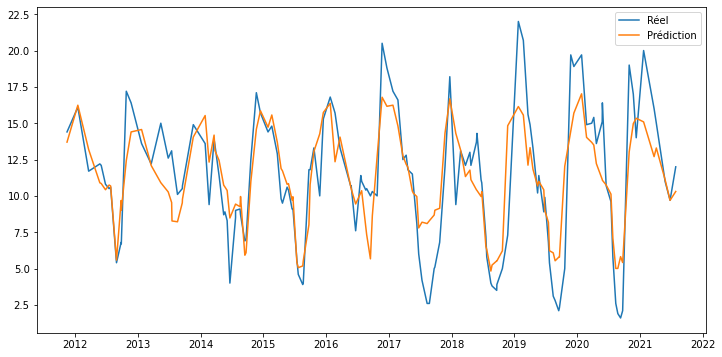

6037400


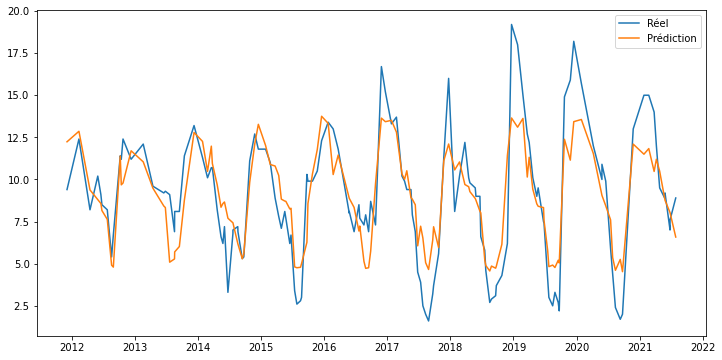

6039500


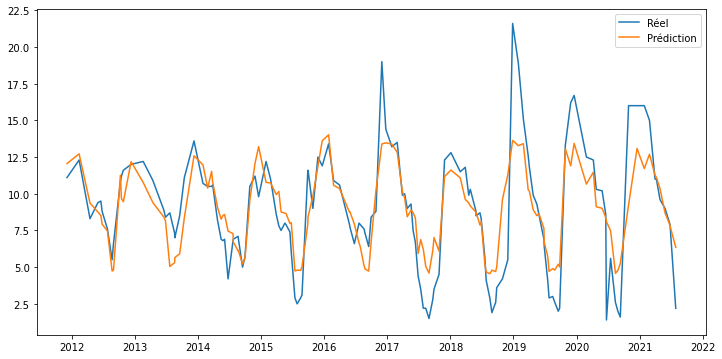

6045800


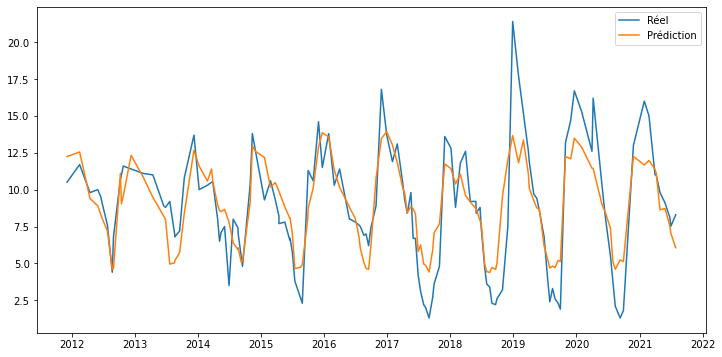

6053800


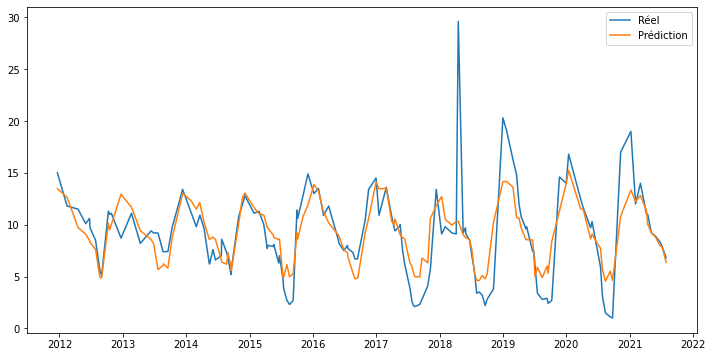

6059500


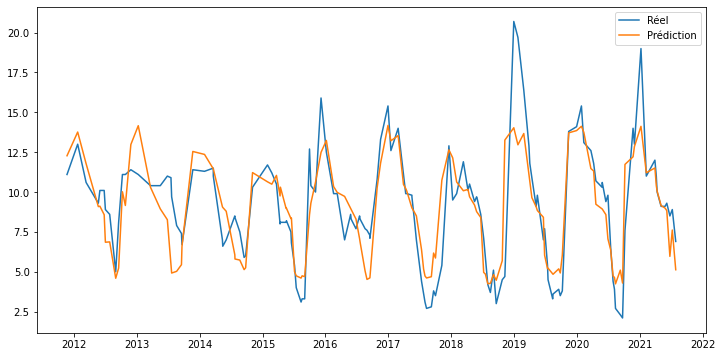

6810010


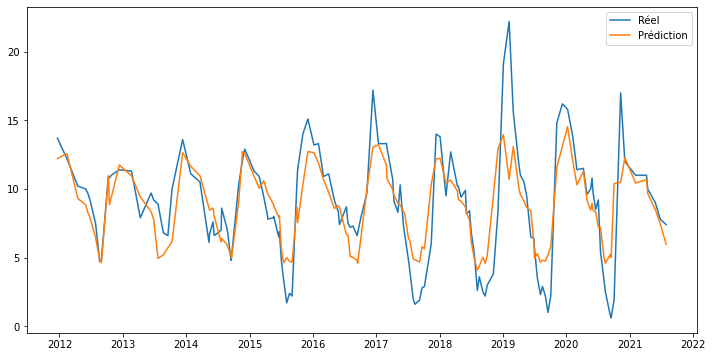

In [86]:
## PLOT STATI0NS PREDICTIONS

station_ids = list(df.station_id.unique())

for st_id in station_ids:
    
    print(st_id)

    # df of the station
    st_bool = df['station_id'] == st_id
    st_df = df[st_bool].sort_values('date') # copy sorted

    # X_station
    X_st = st_df[feature_cols]
    X_st = scaler.transform(X_st) # Scaling

    # y prediction
    y_st_pred = model.predict(X_st)
    st_df['nitrate_pred'] = y_st_pred

    plt.figure(figsize=(12,6))
    plt.plot(st_df['date'],st_df['nitrate'],label='Réel')
    plt.plot(st_df['date'],st_df['nitrate_pred'],label='Prédiction')
    plt.legend()
    plt.show()